In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import matthews_corrcoef as mcc, roc_auc_score as rauc, confusion_matrix, f1_score,\
                                      average_precision_score as ap, PrecisionRecallDisplay as prd

<AxesSubplot:>

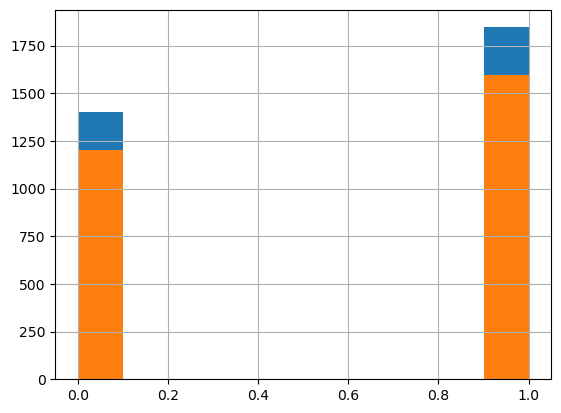

In [19]:
df = pd.read_csv('hospital_deaths_train.csv')
# df = df.fillna(df.mean())
df_1 = df[df['In-hospital_death'] == 1]
df_0 = df[df['In-hospital_death'] == 0]
df.Gender.hist()
df_0.Gender.hist()
# print(df.head())
# print(df.describe(include='all').to_string())

## Feature selection

In [20]:
print(df.shape)
l = abs(df.corr()['In-hospital_death'].values) >= 0.05
df = df.loc[:, l]
print(df.shape)

(3250, 116)
(3250, 76)


## Train_test_split

In [21]:
y = df['In-hospital_death']
X = df.drop(['In-hospital_death'], axis=1)

X = X.fillna(X.mean())
n = np.random.randint(1, 1000)
print(n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=331)
print(y.value_counts())
print(y_train.value_counts())
data = pd.DataFrame(columns=['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC', 'MCC', 'F1', 'AP'])

427
0    2799
1     451
Name: In-hospital_death, dtype: int64
0    2246
1     354
Name: In-hospital_death, dtype: int64


## EDA

In [22]:
f1 = 'BUN_last'
f2 = 'Lactate_last'
# df.corr()['In-hospital_death'].sort_values()

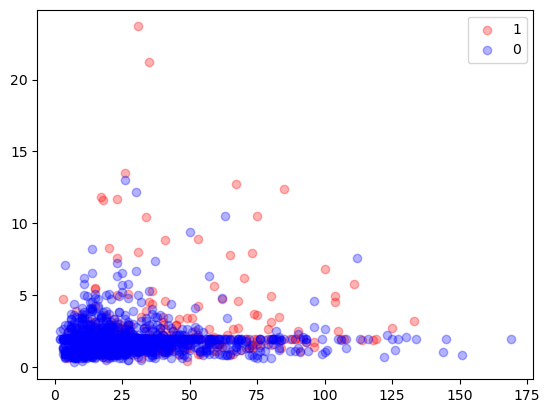

In [23]:
rows = y_train==1
plt.scatter(X_train.loc[y_train == 1, f1], X_train.loc[y_train == 1, f2], label='1', color='red', alpha=0.3)
rows = y[y==0]
plt.scatter(X_train.loc[y_train == 0, f1], X_train.loc[y_train == 0, f2], label='0', color='blue', alpha=0.3)
plt.legend()
plt.show()

## Feature scaling

In [16]:
scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)

In [25]:
!pip install threadpoolctl

## Balancing

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

sm = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=3)
X_train, y_train = sm.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)

y_train.value_counts()

AttributeError: 'NoneType' object has no attribute 'split'

## GaussianNB

In [ ]:
cross_val_score(GaussianNB(), X_train, y_train).mean()

In [ ]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['GaussianNB'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

## MultinomialNB

In [ ]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['MultinomialNB'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

## LDA

In [ ]:
grid = GridSearchCV(LDA(), param_grid={'solver': ['svd', 'lsqr', 'eigen']}, verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
cross_val_score(grid.best_estimator_, X_train, y_train).mean()

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.816923,0.494845,0.873418,0.40678,0.907895,0.684132,0.340416,0.446512,0.392403
LDA,0.756923,0.793814,0.750452,0.35814,0.954023,0.772133,0.412189,0.493590,0.490315


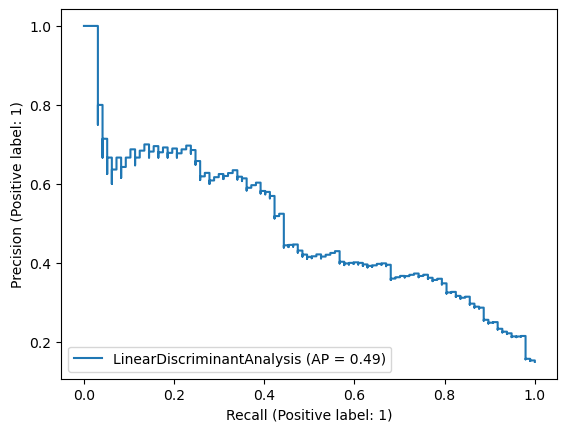

In [93]:
clf = LDA().fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['LDA'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
prd.from_estimator(clf, X_test, y_test)
data

## QDA

In [44]:
grid = GridSearchCV(QDA(), param_grid={'reg_param': np.arange(0, 1, 0.05)}, verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'reg_param': 0.0}

In [52]:
cross_val_score(grid.best_estimator_, X_train, y_train).mean()

0.85

In [94]:
clf = QDA().fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['QDA'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.816923,0.494845,0.873418,0.406780,0.907895,0.684132,0.340416,0.446512,0.392403
LDA,0.756923,0.793814,0.750452,0.358140,0.954023,0.772133,0.412189,0.493590,0.490315
QDA,0.792308,0.463918,0.849910,0.351562,0.900383,0.656914,0.281189,0.400000,0.385486


##  Decision_tree

In [46]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': range(3, 20)}, verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 17 candidates, totalling 85 fits


{'max_depth': 17}

In [47]:
cross_val_score(grid.best_estimator_, X_train, y_train).mean()

0.8521978144486202

In [95]:
clf = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['Decision_tree'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.816923,0.494845,0.873418,0.406780,0.907895,0.684132,0.340416,0.446512,0.392403
LDA,0.756923,0.793814,0.750452,0.358140,0.954023,0.772133,0.412189,0.493590,0.490315
QDA,0.792308,0.463918,0.849910,0.351562,0.900383,0.656914,0.281189,0.400000,0.385486
Decision_tree,0.753846,0.597938,0.781193,0.324022,0.917197,0.689566,0.302414,0.420290,0.323779


[Text(0.5, 0.9, 'x[20] <= -1.053\ngini = 0.239\nsamples = 2600\nvalue = [2239, 361]'),
 Text(0.25, 0.7, 'x[99] <= 1.062\ngini = 0.457\nsamples = 463\nvalue = [299, 164]'),
 Text(0.125, 0.5, 'x[54] <= 0.582\ngini = 0.425\nsamples = 402\nvalue = [279, 123]'),
 Text(0.0625, 0.3, 'x[74] <= 1.371\ngini = 0.36\nsamples = 285\nvalue = [218, 67]'),
 Text(0.03125, 0.1, 'gini = 0.327\nsamples = 267\nvalue = [212, 55]'),
 Text(0.09375, 0.1, 'gini = 0.444\nsamples = 18\nvalue = [6, 12]'),
 Text(0.1875, 0.3, 'x[62] <= -0.521\ngini = 0.499\nsamples = 117\nvalue = [61, 56]'),
 Text(0.15625, 0.1, 'gini = 0.366\nsamples = 29\nvalue = [7, 22]'),
 Text(0.21875, 0.1, 'gini = 0.474\nsamples = 88\nvalue = [54, 34]'),
 Text(0.375, 0.5, 'x[45] <= -0.103\ngini = 0.441\nsamples = 61\nvalue = [20, 41]'),
 Text(0.3125, 0.3, 'x[0] <= 1.558\ngini = 0.137\nsamples = 27\nvalue = [2, 25]'),
 Text(0.28125, 0.1, 'gini = 0.074\nsamples = 26\nvalue = [1, 25]'),
 Text(0.34375, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'

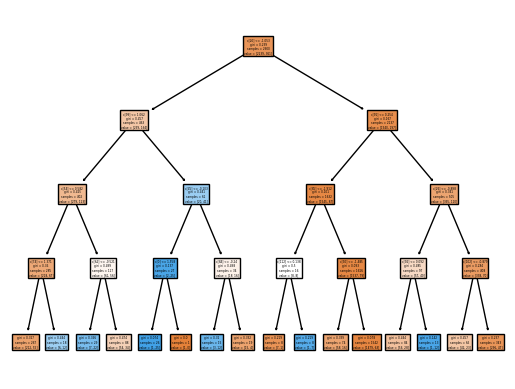

In [57]:
from sklearn.tree import plot_tree
plot_tree(clf, filled=True)

## Bagging

In [52]:
param_grid = {
    'estimator__C': [1, 50, 100, 1000],
    'estimator__loss': ['hinge', 'squared_hinge'],
             }
grid = GridSearchCV(BaggingClassifier(estimator=LinearSVC(), n_estimators=15), param_grid=param_grid, scoring='f1', verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

{'estimator__C': 1, 'estimator__loss': 'hinge'}

C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ARTUR\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.816923,0.494845,0.873418,0.406780,0.907895,0.684132,0.340416,0.446512,0.392403
LDA,0.756923,0.793814,0.750452,0.358140,0.954023,0.772133,0.412189,0.493590,0.490315
QDA,0.792308,0.463918,0.849910,0.351562,0.900383,0.656914,0.281189,0.400000,0.385486
Decision_tree,0.753846,0.597938,0.781193,0.324022,0.917197,0.689566,0.302414,0.420290,0.323779
Bagging-LDA,0.760000,0.793814,0.754069,0.361502,0.954233,0.773942,0.415916,0.496774,0.490000
Bagging-SVM_linear,0.752308,0.731959,0.755877,0.344660,0.941441,0.743918,0.373592,0.468647,0.360000
Bagging-SVM_rbf,0.790769,0.494845,0.842676,0.355556,0.904854,0.668761,0.296469,0.413793,0.330000


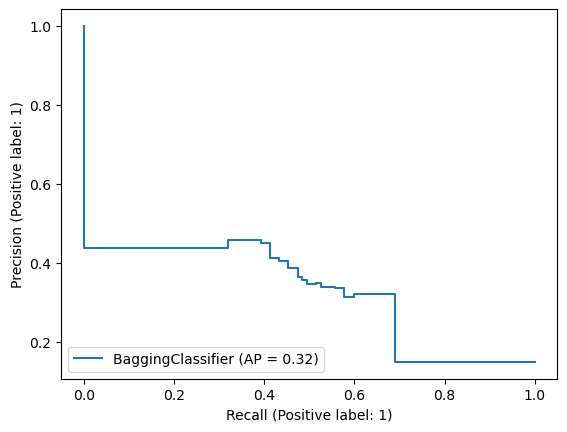

In [100]:
clf = BaggingClassifier(estimator=SVC(kernel='rbf', max_iter=3000), n_estimators=15).fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['Bagging-SVM_rbf'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), 0.33]
prd.from_estimator(clf, X_test, y_test)
data

## imblearn library

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## Balanced-Bagging

In [90]:
cross_val_score(BalancedBaggingClassifier(), X_train, y_train).mean()

0.7946153846153846

In [38]:
clf = BalancedBaggingClassifier(estimator=SVC()).fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['Balanced-Bagging'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.800000,0.460526,0.844948,0.282258,0.922053,0.652737,0.249824,0.350000,0.256011
LDA,0.741538,0.631579,0.756098,0.255319,0.939394,0.693838,0.274747,0.363636,0.325455
QDA,0.840000,0.210526,0.923345,0.266667,0.898305,0.566936,0.148610,0.235294,0.203952
Decision_tree,0.743077,0.552632,0.768293,0.240000,0.928421,0.660462,0.232487,0.334661,0.222594
Bagging,0.116923,1.000000,0.000000,0.116923,NaN,0.500000,0.000000,0.209366,0.128543
Balanced-Bagging,0.880000,0.013158,0.994774,0.250000,0.883901,0.503966,0.032589,0.025000,0.137740


## EasyEnsembleClf

In [51]:
clf = EasyEnsembleClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['Easy-Ensemble'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

NameError: name 'EasyEnsembleClassifier' is not defined

## StackingClassifier

In [ ]:
param_grid = {
    'bootstrap': [True, False], 
    'bootstrap_features':[True, False],
    'n_estimators': [5, 10, 15],
    'max_samples': [0.6, 0.8, 1.0],
    'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'estimator__C': [0.5, 1, 1.5, 2, 3],
    'estimator__degree': [2, 3, 4],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__class_weight': ['balanced', None]
             }
grid = GridSearchCV(StackingClassifier(estimator=SVC()), param_grid=param_grid, scoring='f1', verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
cross_val_score(BalancedBaggingClassifier(), X_train, y_train).mean()

In [104]:
estimators = [
    ('svm', LDA()),
    ('knn', GaussianNB())
]
clf = StackingClassifier(estimators=estimators, final_estimator=make_pipeline(StandardScaler(),
                          LogisticRegression(random_state=42))).fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['Stacking-(LDA, GaussianNB)'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.816923,0.494845,0.873418,0.406780,0.907895,0.684132,0.340416,0.446512,0.392403
LDA,0.756923,0.793814,0.750452,0.358140,0.954023,0.772133,0.412189,0.493590,0.490315
QDA,0.792308,0.463918,0.849910,0.351562,0.900383,0.656914,0.281189,0.400000,0.385486
Decision_tree,0.753846,0.597938,0.781193,0.324022,0.917197,0.689566,0.302414,0.420290,0.323779
Bagging-LDA,0.760000,0.793814,0.754069,0.361502,0.954233,0.773942,0.415916,0.496774,0.490000
Bagging-SVM_linear,0.752308,0.731959,0.755877,0.344660,0.941441,0.743918,0.373592,0.468647,0.360000
Bagging-SVM_rbf,0.790769,0.494845,0.842676,0.355556,0.904854,0.668761,0.296469,0.413793,0.330000
KNN,0.706154,0.690722,0.708861,0.293860,0.928910,0.699791,0.298354,0.412308,0.275368
"Stacking-(LDA, GaussianNB, BaggingClassifier)",0.763077,0.711340,0.772152,0.353846,0.938462,0.741746,0.375937,0.472603,0.490314
"Stacking-(LDA, GaussianNB)",0.769231,0.752577,0.772152,0.366834,0.946785,0.762365,0.405666,0.493243,0.492111


## KNN

In [43]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': range(3, 20, 2)}, verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'n_neighbors': 3}

In [101]:
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)).fit(X_train, y_train)
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
data.loc['KNN'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test,clf.predict_proba(X_test)[:,1])]
data

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
GaussianNB,0.816923,0.494845,0.873418,0.406780,0.907895,0.684132,0.340416,0.446512,0.392403
LDA,0.756923,0.793814,0.750452,0.358140,0.954023,0.772133,0.412189,0.493590,0.490315
QDA,0.792308,0.463918,0.849910,0.351562,0.900383,0.656914,0.281189,0.400000,0.385486
Decision_tree,0.753846,0.597938,0.781193,0.324022,0.917197,0.689566,0.302414,0.420290,0.323779
Bagging-LDA,0.760000,0.793814,0.754069,0.361502,0.954233,0.773942,0.415916,0.496774,0.490000
Bagging-SVM_linear,0.752308,0.731959,0.755877,0.344660,0.941441,0.743918,0.373592,0.468647,0.360000
Bagging-SVM_rbf,0.790769,0.494845,0.842676,0.355556,0.904854,0.668761,0.296469,0.413793,0.330000
KNN,0.706154,0.690722,0.708861,0.293860,0.928910,0.699791,0.298354,0.412308,0.275368


In [105]:
data.sort_values(by='AP', ascending=False)

,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
"Stacking-(LDA, GaussianNB)",0.769231,0.752577,0.772152,0.366834,0.946785,0.762365,0.405666,0.493243,0.492111
LDA,0.756923,0.793814,0.750452,0.358140,0.954023,0.772133,0.412189,0.493590,0.490315
"Stacking-(LDA, GaussianNB, BaggingClassifier)",0.763077,0.711340,0.772152,0.353846,0.938462,0.741746,0.375937,0.472603,0.490314
Bagging-LDA,0.760000,0.793814,0.754069,0.361502,0.954233,0.773942,0.415916,0.496774,0.490000
GaussianNB,0.816923,0.494845,0.873418,0.406780,0.907895,0.684132,0.340416,0.446512,0.392403
QDA,0.792308,0.463918,0.849910,0.351562,0.900383,0.656914,0.281189,0.400000,0.385486
Bagging-SVM_linear,0.752308,0.731959,0.755877,0.344660,0.941441,0.743918,0.373592,0.468647,0.360000
Bagging-SVM_rbf,0.790769,0.494845,0.842676,0.355556,0.904854,0.668761,0.296469,0.413793,0.330000
Decision_tree,0.753846,0.597938,0.781193,0.324022,0.917197,0.689566,0.302414,0.420290,0.323779
KNN,0.706154,0.690722,0.708861,0.293860,0.928910,0.699791,0.298354,0.412308,0.275368


## Choosing best threshold for best estimator

In [23]:
clf = LDA().fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
# print(list(zip(clf.predict_proba(X_test), clf.predict(X_test) == list(y_test))))
for t in np.arange(0., 1., 0.1):
    y_pred = probs > t
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    data.loc[f'LDA {t}'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test, probs)]
data

C:\Users\ARTUR\AppData\Local\Temp\ipykernel_892\2273292483.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  data.loc[f'LDA {t}'] = [(tp + tn)/(tp + fp + tn + fn), tp/(tp+fn), tn/(tn + fp), tp/(tp + fp), tn/(tn + fn), rauc(y_test, y_pred), mcc(y_test, y_pred), f1_score(y_test, y_pred), ap(y_test, probs)]


,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,MCC,F1,AP
LDA0.3,0.630769,0.886598,0.585895,0.273016,0.967164,0.736247,0.336873,0.417476,0.481352
LDA0.4,0.689231,0.855670,0.660036,0.306273,0.963061,0.757853,0.372689,0.451087,0.481352
LDA0.5,0.747692,0.814433,0.735986,0.351111,0.957647,0.775209,0.412245,0.490683,0.481352
LDA0.6,0.790769,0.680412,0.810127,0.385965,0.935282,0.745269,0.396969,0.492537,0.481352
LDA0.7,0.816923,0.546392,0.864376,0.414062,0.915709,0.705384,0.368048,0.471111,0.481352
LDA 0.0,0.149231,1.000000,0.000000,0.149231,NaN,0.500000,0.000000,0.259705,0.481352
LDA 0.1,0.433846,0.979381,0.338156,0.206074,0.989418,0.658768,0.249150,0.340502,0.481352
LDA 0.2,0.561538,0.927835,0.497288,0.244565,0.975177,0.712561,0.305643,0.387097,0.481352
LDA 0.30000000000000004,0.630769,0.886598,0.585895,0.273016,0.967164,0.736247,0.336873,0.417476,0.481352
LDA 0.4,0.689231,0.855670,0.660036,0.306273,0.963061,0.757853,0.372689,0.451087,0.481352
